# Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import datasets

sns.set()

In [6]:
# load & format iris dataset
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['species'] = [iris.target_names[i] for i in iris.target]

# petal lenghts of each species
setosa_petal_length = iris_df.loc[iris_df['species'] == 'setosa', 'petal length (cm)'].to_numpy()
versicolor_petal_length = iris_df.loc[iris_df['species'] == 'versicolor', 'petal length (cm)'].to_numpy()
virginica_petal_length = iris_df.loc[iris_df['species'] == 'virginica', 'petal length (cm)'].to_numpy()

# petal lenghts of each species
setosa_petal_width = iris_df.loc[iris_df['species'] == 'setosa', 'petal width (cm)'].to_numpy()
versicolor_petal_width = iris_df.loc[iris_df['species'] == 'versicolor', 'petal width (cm)'].to_numpy()
virginica_petal_width = iris_df.loc[iris_df['species'] == 'virginica', 'petal width (cm)'].to_numpy()


# Linear Regression
## Pearson Correlation Coefficient


In [49]:
# pearson r from covariance matrix (ddof=1)
covariance_matrix = np.cov(versicolor_petal_length, versicolor_petal_width)
petal_cov = covariance_matrix[0, 1]
length_sd = np.sqrt(covariance_matrix[0,0])
width_sd = np.sqrt(covariance_matrix[1,1])
pearsonr_from_covmat = petal_cov / (length_sd * width_sd)

# pearson r from correlation matrix
correlation_matrix = np.corrcoef(versicolor_petal_length, versicolor_petal_width)
pearsonr_from_corrmat = correlation_matrix[0, 1]

# manual pearson r (https://stackoverflow.com/questions/21030668/why-do-numpy-cov-diagonal-elements-and-var-functions-have-different-values)
covariance_matrix = np.cov(versicolor_petal_length, versicolor_petal_width, ddof=0)
petal_cov = covariance_matrix[0, 1]
length_sd = np.std(versicolor_petal_length)
width_sd = np.std(versicolor_petal_width)
manual_pearsonr = correlation_matrix[0, 1]

# pearson r
stats_pearsonr = stats.pearsonr(versicolor_petal_length, versicolor_petal_width)

# comparing values
print('cov: {:0.4f} - corr: {:0.4f} - manual: {:0.4f} - stats: {:0.4f}'.format(pearsonr_from_covmat, pearsonr_from_corrmat, manual_pearsonr, stats_pearsonr[0]))


cov: 0.7867 - corr: 0.7867 - manual: 0.7867 - stats: 0.7867


## Linear Regression

In [48]:
# manual linear regression by least squares
slope, intercept = np.polyfit(versicolor_petal_length, versicolor_petal_width, 1)

# residual sum of squares (RSS)
slope_candidates = np.linspace(0.2622, 0.4, 200)
rss = np.empty_like(slope_candidates)
for i, slope_candidate in enumerate(slope_candidates):
    rss[i] = np.sum((versicolor_petal_width - (slope_candidate * versicolor_petal_length + intercept))**2)

print('petal width (cm) = {:0.4f} * petal length (cm) + {:0.4f}'.format(slope, intercept))


petal width (cm) = 0.3311 * petal length (cm) + -0.0843


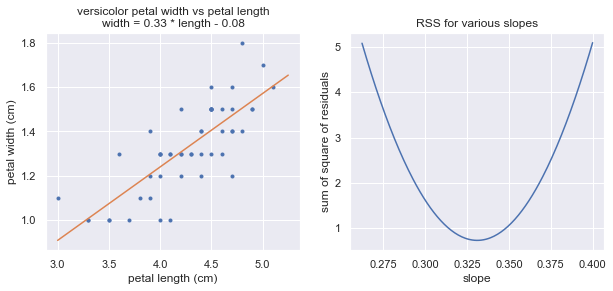

In [47]:
# fig
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*5, 1*4))

# graph
_ = ax1.plot(versicolor_petal_length, versicolor_petal_width, linestyle='none', marker='.')

# linear regression
x = np.array([3, 5.25])
y = slope * x + intercept
_ = ax1.plot(x, y)

# Plot the RSS
ax2.plot(slope_candidates, rss, '-')

# labels
_ = ax1.set_xlabel('petal length (cm)')
_ = ax1.set_ylabel('petal width (cm)')
_ = ax2.set_xlabel('slope')
_ = ax2.set_ylabel('sum of square of residuals')

# titles
_ = ax1.set_title('versicolor petal width vs petal length\nwidth = 0.33 * length - 0.08')
_ = ax2.set_title('RSS for various slopes')


## Pairs Bootstrap for Confidence Intervals

In [51]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(x))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps


95% Confidence Interval: [0.258 0.333 0.418]


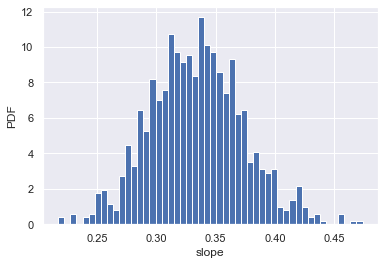

In [62]:
# bootstrap estimates
seed = np.random.seed(42)
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(versicolor_petal_length, versicolor_petal_width, size=1000)

# Compute and print 95% CI for slope
print('95% Confidence Interval: {}'.format(np.percentile(bs_slope_reps, [2.5, 50, 97.5]).round(3)))

# Plot the histogram
_ = plt.hist(bs_slope_reps, bins=50, normed=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
plt.show()


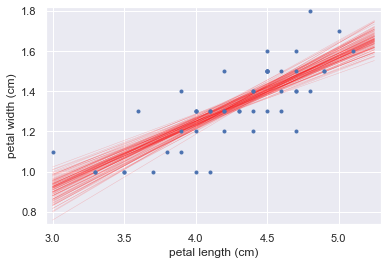

In [63]:
# Generate array of x-values for bootstrap lines: x
x = np.array([3, 5.25])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, 
                 bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
_ = plt.plot(versicolor_petal_length, versicolor_petal_width, linestyle='none', marker='.')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('petal length (cm)')
_ = plt.ylabel('petal width (cm)')
plt.margins(0.02)
plt.show()


## Test of Correlation

We can use permutation samples to test if the observed correlation could have occurred by chance.


In [66]:
# Compute observed correlation: r_obs
r_obs = stats.pearsonr(versicolor_petal_length, versicolor_petal_width)[0]

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    versicolor_petal_width_permuted = np.random.permutation(versicolor_petal_width)

    # Compute Pearson correlation
    perm_replicates[i] = stats.pearsonr(versicolor_petal_length, versicolor_petal_width_permuted)[0]


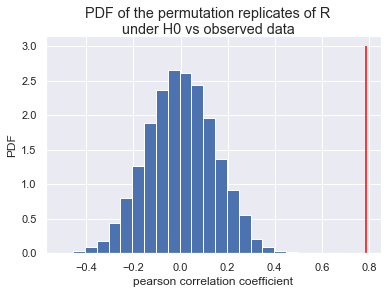

In [69]:
# show histogram
_ = plt.hist(perm_replicates, bins=20, normed=True)
_ = plt.vlines(r_obs, 0, 3, color='red')
_ = plt.xlabel('pearson correlation coefficient')
_ = plt.ylabel('PDF')
_ = plt.suptitle('PDF of the permutation replicates of R\nunder H0 vs observed data')


In [70]:
# Compute p-value: p
p = sum(perm_replicates >= r_obs) / len(perm_replicates)
print('p-val =', p)


p-val = 0.0
